<a href="https://colab.research.google.com/github/hsingh137/image_classification_with_rnn/blob/main/Image_Classification_Rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# manual installation of PyTorch library
!pip3 install torch torchvision idx2numpy torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=7eb8297f5c39aef7f3ae927ee699159f2458df425195343d4f2cd4130fa51938
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [17]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim  as optim
import idx2numpy

import gzip
from torchviz import make_dot

import os
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

### Load and Explore dataset 

In [3]:
# list all transformations
transform = transforms.Compose(
    [transforms.ToTensor()])


# download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True , transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 176641307.42it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 99047991.68it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 207217719.75it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 4014863.81it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#### Viewing some images 

In [ ]:
def show_img(idx, tdata , label_data):
  test_img = tdata[idx]
  label = label_data[idx]

  test_img = test_img.numpy()
  print('Number is:' , label)
  plt.imshow(test_img)

Number is: tensor(0)


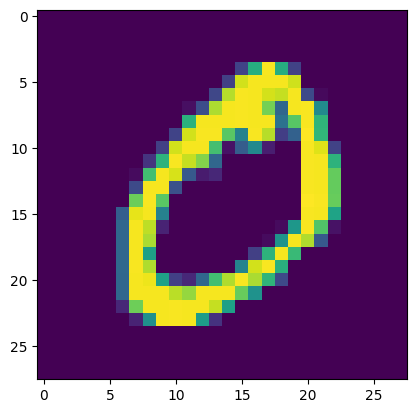

In [ ]:
show_img(1, trainset.data , trainset.targets)

Number is: tensor(7)


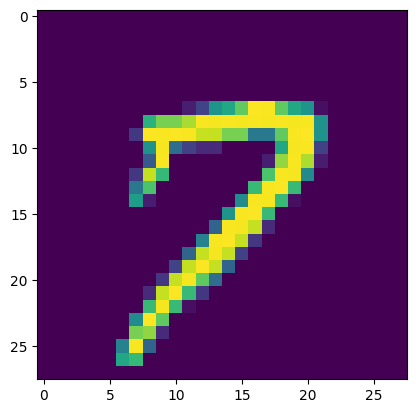

In [ ]:
show_img(599, trainset.data , trainset.targets)

In [ ]:
transform( transforms.ToTensor()(np.array(arr[0])))

TypeError: ignored

#### Create a trainloader

In [18]:
class ImageDataset(Dataset):
    def __init__(self, img_file , lbl_file  , transform = None):
      self.train_arr = idx2numpy.convert_from_file(img_file)
      self.lbl_arr = idx2numpy.convert_from_file(lbl_file)

       # adding transform 
      self.transform = transform



    def __getitem__(self , idx):
      # need to add transform 
        if transform: 
          img = np.array(self.train_arr[idx])
          img = self.transform(img)
        else: 
          print('return you need to add a transforms for the train data ')
        target = self.lbl_arr[idx]
        return img , target

    def __len__(self):
      return len(self.lbl_arr)




In [19]:

train_file = '/content/data/MNIST/raw/train-images-idx3-ubyte'
lbl_file = '/content/data/MNIST/raw/train-labels-idx1-ubyte'

trainset = ImageDataset(img_file = train_file , lbl_file = lbl_file  , transform = transforms.ToTensor())

BATCH_SIZE = 64
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

In [20]:
test_file = '/content/data/MNIST/raw/t10k-images-idx3-ubyte'
test_lbl_file = '/content/data/MNIST/raw/t10k-labels-idx1-ubyte'

testset = ImageDataset(img_file = test_file , lbl_file = test_lbl_file  , transform = transforms.ToTensor())

BATCH_SIZE = 64
testloader = DataLoader(testset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

In [21]:
next(iter(trainloader))[0].shape

torch.Size([64, 1, 28, 28])

In [22]:
next(iter(testloader))[0].shape

torch.Size([64, 1, 28, 28])

### RNN class

In [23]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [24]:
class ImageRNN(nn.Module):
  def __init__(self, input_size , hidden_dim, output_size):
    # this is where the parameters of the model go 
    super(ImageRNN, self).__init__()

    self.input_size = input_size 
    self.hidden_dim = hidden_dim 
    self.output_size = output_size 

    self.RNN = nn.RNN(self.input_size , self.hidden_dim  , batch_first = True)

    self.fc = nn.Linear(self.hidden_dim ,  self.output_size)

  def init_hidden(self, batch_size):
      # This method generates the first hidden state of zeros which we'll use in the forward pass
      # We'll send the tensor holding the hidden state to the device we specified earlier as well
      self.batch_size= batch_size
      hidden = torch.rand(1, batch_size, self.hidden_dim)
      return hidden


  def forward(self , x ):
    # get batch_size
    batch_size = x.size(0)
    # x = x.permute(1, 0, 2) 
    # x = x.view()

    # initalise hidden state
    hidden = self.init_hidden(batch_size)

    # feed rnn 
    _ , hidden = self.RNN(x , hidden)
  
    # classify 
    out = self.fc(hidden)
    # out = out.squeeze()

    return out.view( -1 , self.output_size)

  


### Test model 

In [25]:

input_size = 28
hidden_dim = 30
output_size =  10
batch_size = 64 

In [26]:
dataiter = iter(trainloader)
images , label = next(dataiter)
images = images.view(batch_size , -1, input_size)
images.shape

torch.Size([64, 28, 28])

In [27]:
model0 = ImageRNN(input_size, hidden_dim, output_size)

In [28]:
y = model0(images)

In [29]:
y.shape

torch.Size([64, 10])

In [31]:
make_dot(y.mean(), params=dict(model0.named_parameters())).render("attached", format="png")

'attached.png'

### Train Model

In [46]:
model0 = ImageRNN(input_size, hidden_dim, output_size)

In [400]:
param0 = list(model0.parameters())
param = list(model.parameters())

In [48]:
criterion = nn.CrossEntropyLoss()
adam = optim.Adam(model0.parameters() , lr = 0.001)

In [49]:
n_epochs = 3

In [50]:

for epoch in range(0, n_epochs , 1): 
  total_loss = 0 
  train_acc = 0.0
  model0.train()

  for i, data  in enumerate(trainloader):
    # initalize the loss
    adam.zero_grad()

    # get the data
    inputs, labels = data
    inputs = inputs.view(batch_size , -1,1)

        

    # forward
    preds = model0(inputs)

    # calcualte loss
    loss = criterion(preds, labels)
    loss.backward()
    adam.step()

    # add loss
    
    total_loss += loss.detach().item()

    # calucalte accuracy 
    out_labels = torch.argmax(preds, 1).data
    correct  = (out_labels == labels ).sum()
    train_acc += correct

    if i%5 == 0 and i!=0:
      print(f'{i}: {total_loss/i} ') 

  print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, total_loss/i, (train_acc/(i*64))*100 ))
    

5: 2.757499885559082 
10: 2.5335843563079834 
15: 2.457193152109782 
20: 2.4181712746620176 
25: 2.395171718597412 
30: 2.3805060227711996 
35: 2.3691701003483363 
40: 2.3599657297134398 
45: 2.3537329302893744 
50: 2.349967541694641 
55: 2.344926556673917 
60: 2.3415377259254457 
65: 2.337994102331308 
70: 2.3360272203172956 
75: 2.3338978989919026 
80: 2.331394559144974 
85: 2.3293703696307015 
90: 2.327591633796692 
95: 2.3265369741540205 
100: 2.3254865837097167 
105: 2.3242548738207134 
110: 2.322662854194641 
115: 2.3219860035440196 
120: 2.3214084347089132 
125: 2.3207894458770753 
130: 2.3202001113158004 
135: 2.3193442009113454 
140: 2.318551891190665 
145: 2.31801176071167 
150: 2.3174806467692055 
155: 2.3169339872175647 
160: 2.31651331782341 
165: 2.316177009813713 
170: 2.315733868935529 
175: 2.3153022861480714 
180: 2.3150207956631976 
185: 2.3146305174440953 
190: 2.3141515669069794 
195: 2.31382890970279 


KeyboardInterrupt: ignored

In [407]:
# TEST ACCURACY
model.eval()
test_acc = 0.0
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)

    outputs = model0(inputs)
    # calucalte accuracy 
    out_labels = torch.argmax(outputs, 1).data
    correct  = (out_labels == labels ).sum()
    test_acc += correct
        
print('Test Accuracy: %.2f'%(test_acc / (i*64) ))

Test Accuracy: 0.93


In [406]:
test_acc

tensor(9327.)

In [348]:
loss

tensor(0.8072, grad_fn=<NllLossBackward0>)

## From the tutorial

In [33]:
# list all transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

# download and load training dataset
trainset2 = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader2 = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

In [327]:
class ImageRNN2(nn.Module):
    
    # declaraction of variables
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(ImageRNN2, self).__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons) 
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
    
    # initialize hidden weights that have zero values
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()

        # lstm_out => n_steps, batch_size, n_neurons (hidden states for each time step)
        # self.hidden => 1, batch_size, n_neurons (final state from each lstm_out)
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs) # batch_size X n_output

In [328]:

# parameters 
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 10

In [332]:
# Training the model
   
import torch.optim as optim

# Device: you can choose what device that you want to use during the training process
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN2(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [333]:
for epoch in range(N_EPHOCS):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(trainloader):
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states

        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss/i, train_acc/i))
    


Epoch: 0 | Loss: 0.6096 | Train Accuracy: 80.87


KeyboardInterrupt: ignored